Progetto: Stimare il valore di appartamenti in California
===========================================

Il modello risultante sarà utilizzato per alimentare un successivo sistema che da delle indicazioni di investimento immobiliare.

Seleziona misura di performance => Errore quadratico medio, Root Mean Square Error
Overview dei dati

Esempio
https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


## Dizionario dei dati
* longitude, latitude => posizione del distretto
* housing_median:age => età media degli immobli
* total_rooms, total_bedrooms => numero totale di stanze nel distretto
* population => popolazione del distretto
* households => numero di immobili
* median_income => reddito medio / 10000 (es: 0,5 = 5000 USD, 12.5 = 12500 USD), limitato all'intervallo 0.5 - 15.0 circa
* median_house_value => valore medio delle case nel territorio
* ocean_proximity => se vicino al mare o no

In [12]:
# Load the california-housing-prices.csv into a Pandas dataset.
def load_housing_data():
    csv_path = os.path.join("datasets", "california-housing-prices.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

## Esplorare i dati

In [15]:
# avere una prima panormaica dei dati
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [10]:
housing.info()
# notare che circa 200 righe non hanno la feature "total_bedrooms"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [21]:
# quali sono i valori di ocean_proximity ?
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [24]:
# overview delle feature numeriche
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000208B99D2A88>,
      dtype=object)

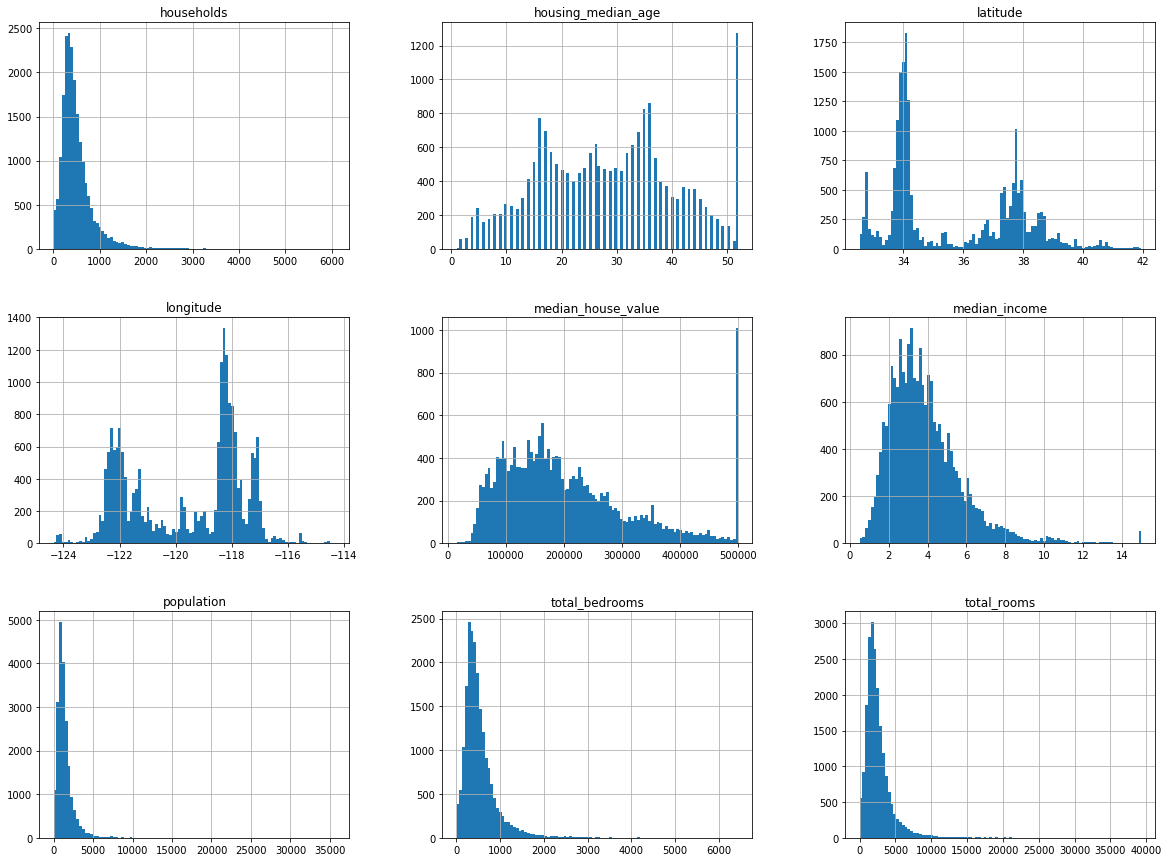

In [34]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
housing.hist(bins=100, figsize=(20,15))

In [36]:
# suddivisione randomica dei dati in set di training e set di test
def split_train_test(data, test_ratio):
    
    # crea un array con i numeri 1, 2... fino alla lunghezza dei dati, in cui i numeri appaiono in ordine casuale
    shuffled_indices = np.random.permutation(len(data))
    
    # calcola la dimensione dei dati di test come percentuale di tutti i dati
    test_set_size = int(len(data) * test_ratio)
    
    # estrae i numeri disordinati presenti nelle posizioni [0 - test_set_size)
    test_indices = shuffled_indices[:test_set_size]
    
    # estrae i numeri disordinati presenti nelle posizioni [test_set_size, fine]
    train_indices = shuffled_indices[test_set_size:]
    
    # restituisce due data frame
    # 1. con i dati i cui indici sono negli indici di training
    # 2. con i dati i cui indici sono negli indici di test
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

In [43]:
len(train_set)

16512

In [51]:
len(test_set)

4128

![California](https://www.freeworldmaps.net/united-states/california/california-counties-map.jpg)

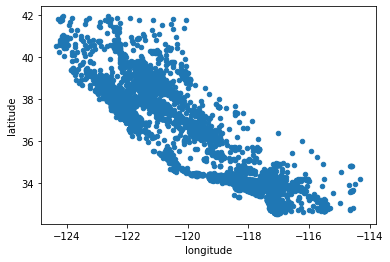

In [50]:
train_set.plot(kind="scatter", x="longitude", y="latitude")

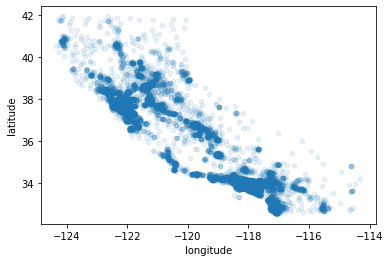

In [53]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

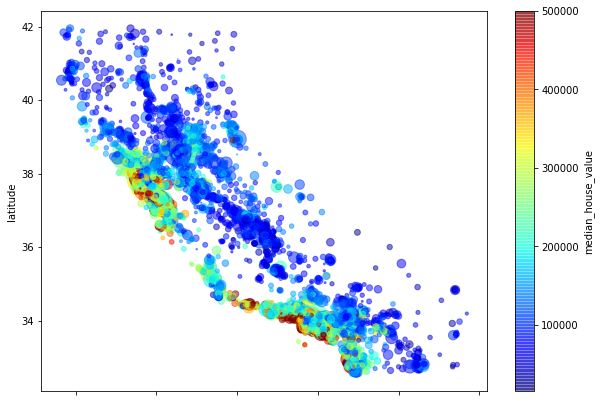

In [66]:
train_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=housing["population"]/50, 
               c="median_house_value", cmap=plt.get_cmap("jet"), figsize=(10,7), colorbar=True)
